# Titanic Survivor Prediction Machine Learning Project

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['axes.unicode_minus']=False

In [78]:
dtc=DecisionTreeClassifier()
dtr=DecisionTreeRegressor()
lgb=LGBMClassifier()
ss=StandardScaler()
mm=MinMaxScaler()
rs=RobustScaler()

## 1. Data 불러오기

In [4]:
train=pd.read_csv("./titanic/train.csv")
test=pd.read_csv("./titanic/test.csv")
submission=pd.read_csv("./titanic/gender_submission.csv")

## 2. Data EDA

In [108]:
# 간단한 전처리
train.drop({'Name','Ticket','Cabin'},axis=1,inplace=True)
train['Sex']=train['Sex'].replace('male',0)
train['Sex']=train['Sex'].replace('female',1)
test['Sex']=test['Sex'].replace('male',0)
test['Sex']=test['Sex'].replace('female',1)
train['Embarked']=train['Embarked'].replace('S',0)
train['Embarked']=train['Embarked'].replace('C',1)
train['Embarked']=train['Embarked'].replace('Q',2)

In [63]:
train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,7.2500,0.0
1,2,1,1,1,38.0,1,0,71.2833,1.0
2,3,1,3,1,26.0,0,0,7.9250,0.0
3,4,1,1,1,35.0,1,0,53.1000,0.0
4,5,0,3,0,35.0,0,0,8.0500,0.0
...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.0,0,0,13.0000,0.0
887,888,1,1,1,19.0,0,0,30.0000,0.0
888,889,0,3,1,NaN,1,2,23.4500,0.0
889,890,1,1,0,26.0,0,0,30.0000,1.0


<AxesSubplot:>

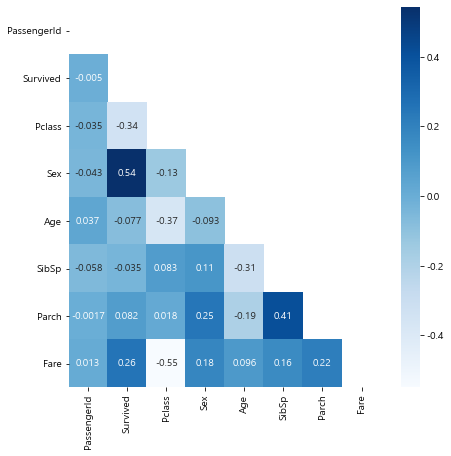

In [20]:
mask=np.zeros_like(train.corr(),dtype=bool)
mask[np.triu_indices_from(mask)]=True

plt.figure(figsize=(7,7))
sns.heatmap(train.corr(),annot=True,mask=mask,cmap='Blues')

절댓값 0.4 이상이면 상관관계를 갖는다고 본다

성별과 생존여부, Pclass와 Fare, Parch와 SibSp는 상관관계가 있다

In [39]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

<AxesSubplot:title={'center':'Fare'}, xlabel='Fare', ylabel='Density'>

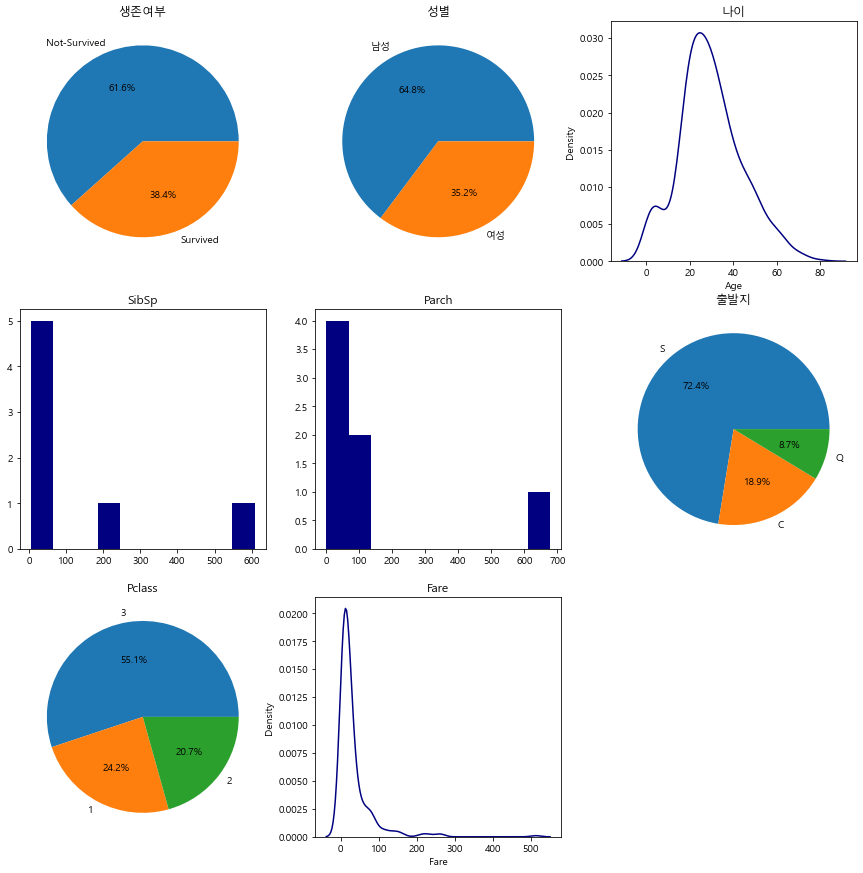

In [74]:
plt.figure(figsize=(15,15))
plt.subplot(331)
plt.title('생존여부')
plt.pie(train['Survived'].value_counts(),labels=['Not-Survived','Survived'],autopct='%.1f%%')
plt.subplot(332)
plt.title('성별')
plt.pie(train['Sex'].value_counts(),labels=['남성','여성'],autopct='%.1f%%')
plt.subplot(333)
plt.title('나이')
sns.kdeplot(train['Age'],color='navy')
plt.subplot(334)
plt.title('SibSp')
plt.hist(train['SibSp'].value_counts(),color='navy')
plt.subplot(335)
plt.title('Parch')
plt.hist(train['Parch'].value_counts(),color='navy')
plt.subplot(336)
plt.title('출발지')
plt.pie(train['Embarked'].value_counts(),labels=['S','C','Q'],autopct='%.1f%%')
plt.subplot(337)
plt.title('Pclass')
plt.pie(train['Pclass'].value_counts(),labels=[3,1,2],autopct='%.1f%%')
plt.subplot(338)
plt.title('Fare')
sns.kdeplot(train['Fare'],color='navy')

## 3. Data 전처리

In [75]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

## 3-4. 모델 선택 및 훈련

Age를 DecisionTreeRegression으로 예측한다

In [88]:
age_train=train[~train['Age'].isna()]
age_test=train[train['Age'].isna()]

In [89]:
age_features=['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch','Fare']
age_target='Age'

In [90]:
age_X_train=age_train[age_features]
age_X_test=age_test[age_features]
age_Y_train=age_train[age_target]

In [95]:
dtr.fit(age_X_train,age_Y_train)

DecisionTreeRegressor()

In [98]:
age_result=dtr.predict(age_X_test)

In [100]:
age_test.reset_index(inplace=True)
age_test['Age']=age_result
age_test['Age']=age_test['Age'].astype(int)

<ipython-input-100-7f0d0cdd2b5a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_test['Age']=age_result
<ipython-input-100-7f0d0cdd2b5a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_test['Age']=age_test['Age'].astype(int)


In [102]:
age_test.drop('index',axis=1,inplace=True)

C:\Users\suyeo\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [104]:
train_new=pd.concat([age_train,age_test])

test set에 대해서도 똑같은 작업 실행

In [111]:
age_features=['Pclass', 'Sex', 'SibSp', 'Parch','Fare']
age_target='Age'
age_train=test[~test['Age'].isna()]
age_test=test[test['Age'].isna()]
age_train.fillna(0,inplace=True)
age_X_train=age_train[age_features]
age_X_test=age_test[age_features]
age_Y_train=age_train[age_target]
dtr.fit(age_X_train,age_Y_train)
age_result=dtr.predict(age_X_test)
age_test.reset_index(inplace=True)
age_test['Age']=age_result
age_test['Age']=age_test['Age'].astype(int)
age_test.drop('index',axis=1,inplace=True)
test_new=pd.concat([age_train,age_test])

C:\Users\suyeo\Anaconda3\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-111-bf25e213d179>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_test['Age']=age_result
<ipython-input-111-bf25e213d179>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

## 4. 모델 선택 및 훈련

Decision Tree Classifier를 사용

In [116]:
features=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch','Fare']
target='Survived'

In [117]:
X_train=train_new[features]
X_test=test_new[features]
Y_train=train_new[target]

In [118]:
dtc.fit(X_train,Y_train)

DecisionTreeClassifier()

In [120]:
result=dtc.predict(X_test)

In [121]:
subm=submission.copy()

In [124]:
subm['Survived']=result

In [125]:
subm.to_csv("ver.1.0.csv",index=False)

In [127]:
accuracy_score(submission['Survived'],result)

0.5287081339712919

## 5. 모델 교차검증(조정)

In [135]:
kf=KFold(n_splits=5)
cv_accuracy=[]
n=0